# <span style="color:#900C3F;">Mice Protein Expression Data Analysis</span>

### <span style="color:#5E5C5B;">In this notebook, using mice protein expression data, we construct frequent pattern mining models and clustering analysis models, and implement them above on the data, and analyze the performance of each classification model.</span> 

### <span style="color:#900C3F;">Steps taken:</span> 

1. **Setting up the environment.**
2. **Preparing Data for Analysis.**
3. **Implementation and Model evaluation.**
4. **Comparing the performance of classification models.**

## <span style="color:#900C3F;">1. Setting up the environment</span>

**Importing requried libraries**

Mainly used:
- **Apache spark** in this project, so we import the some libraries required, **pyspark** for starting a **spark session.** 
- **pandas** for data analysis and manipulation.
- **sklearn** for statistical modeling including classification.
- **plotly** for visualization.

In [106]:
import pandas as pd
import numpy as np
import pprint
from sklearn import metrics, svm
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import plotly.graph_objects as go
import plotly.express as px
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth
import scipy.cluster.hierarchy as sch

## <span style="color:#900C3F;">2. Preparing Data for Analysis</span>

**Preparing** dataset taken from http://archive.ics.uci.edu/ml/index.php for the analysis.




In [4]:
#reading the file with pandas's method read_excel, converting the csv file to a dataframe
def readCSVtoDF(csvData):
    return pd.read_excel(csvData)

rawData = 'data/Data_Cortex_Nuclear.xls'

DF = readCSVtoDF(rawData)

In [5]:
DF

,MouseID,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
0,309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,...,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
1,309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,...,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
2,309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,...,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
3,309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,...,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
4,309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,...,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,Control,Memantine,C/S,c-CS-m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075,J3295_11,0.254860,0.463591,0.254860,2.092082,2.600035,0.211736,0.171262,2.483740,0.207317,...,0.183324,0.374088,0.318782,0.204660,0.328327,1.364823,Ts65Dn,Saline,S/C,t-SC-s
1076,J3295_12,0.272198,0.474163,0.251638,2.161390,2.801492,0.251274,0.182496,2.512737,0.216339,...,0.175674,0.375259,0.325639,0.200415,0.293435,1.364478,Ts65Dn,Saline,S/C,t-SC-s
1077,J3295_13,0.228700,0.395179,0.234118,1.733184,2.220852,0.220665,0.161435,1.989723,0.185164,...,0.158296,0.422121,0.321306,0.229193,0.355213,1.430825,Ts65Dn,Saline,S/C,t-SC-s
1078,J3295_14,0.221242,0.412894,0.243974,1.876347,2.384088,0.208897,0.173623,2.086028,0.192044,...,0.196296,0.397676,0.335936,0.251317,0.365353,1.404031,Ts65Dn,Saline,S/C,t-SC-s


In [6]:
DF['MouseNumber'] = DF.MouseID.apply(lambda x: x.split('_')[0]) 
DF['MeasurementNumber'] = DF.MouseID.apply(lambda x: x.split('_')[1])
DF.drop(['MouseID'], axis=1, inplace=True)  

In [7]:
DF

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class,MouseNumber,MeasurementNumber
0,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,...,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m,309,1
1,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,...,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m,309,2
2,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,...,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m,309,3
3,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,...,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m,309,4
4,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,...,0.118481,0.140314,0.148380,1.839730,Control,Memantine,C/S,c-CS-m,309,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075,0.254860,0.463591,0.254860,2.092082,2.600035,0.211736,0.171262,2.483740,0.207317,1.057971,...,0.318782,0.204660,0.328327,1.364823,Ts65Dn,Saline,S/C,t-SC-s,J3295,11
1076,0.272198,0.474163,0.251638,2.161390,2.801492,0.251274,0.182496,2.512737,0.216339,1.081150,...,0.325639,0.200415,0.293435,1.364478,Ts65Dn,Saline,S/C,t-SC-s,J3295,12
1077,0.228700,0.395179,0.234118,1.733184,2.220852,0.220665,0.161435,1.989723,0.185164,0.884342,...,0.321306,0.229193,0.355213,1.430825,Ts65Dn,Saline,S/C,t-SC-s,J3295,13
1078,0.221242,0.412894,0.243974,1.876347,2.384088,0.208897,0.173623,2.086028,0.192044,0.922595,...,0.335936,0.251317,0.365353,1.404031,Ts65Dn,Saline,S/C,t-SC-s,J3295,14


### <span>Dataset</span>

**Number of instances and Number of attributes**

In [8]:
DF.shape

(1080, 83)

**Preprocessing data**

In [9]:
isNullGenotype = len(DF[pd.isnull(DF["Genotype"])])
isNullTreatment = len(DF[pd.isnull(DF["Treatment"]) ]) 
isNullBehavior = len(DF[pd.isnull(DF["Behavior"])]) 
print(isNullGenotype, isNullTreatment, isNullBehavior)

0 0 0


In [10]:
DF['BCL2_N'][:20] #to check if there is null values in BCL2_N column

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10         NaN
11         NaN
12         NaN
13         NaN
14         NaN
15    0.178604
16    0.143588
17    0.132887
18    0.182391
19    0.163775
Name: BCL2_N, dtype: float64

In [11]:
#replacing missing values with mean values of each column
meanValues = DF.groupby(by=['class']).mean().reset_index()  #mean values of numerical attributes

classValue = 'class'
def handleNullValues(row, column):
    value = row[column]
    if pd.isnull(value):
        return meanValues.loc[meanValues[classValue] == row[classValue], column], True
    return value, False

for i, row in DF.iterrows():  #series for each row
    for column in DF.columns:
        row[column], handled = handleNullValues(row, column)
    DF.iloc[i] = row

In [12]:
DF['BCL2_N'][:20] # to check if null values are filled by mean value in BCL2_N column

0     0.132539
1     0.132539
2     0.132539
3     0.132539
4     0.132539
5     0.132539
6     0.132539
7     0.132539
8     0.132539
9     0.132539
10    0.132539
11    0.132539
12    0.132539
13    0.132539
14    0.132539
15    0.178604
16    0.143588
17    0.132887
18    0.182391
19    0.163775
Name: BCL2_N, dtype: float64

In [152]:
def minMaxNormalization(df):
    # copy the dataframe
    df_norm = df.copy()
    # apply min-max scaling
    for column in df_norm.columns[:77]:  #for numeric values
        df_norm[column] = (df_norm[column] - df_norm[column].min()) / (df_norm[column].max() - df_norm[column].min())
        
    return df_norm
    
# call the min_max_scaling function
normalizedDF = minMaxNormalization(DF)

normalizedDF

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class,MouseNumber,MeasurementNumber
0,0.151122,0.212885,0.824638,0.612119,0.630482,0.327006,0.448666,0.168257,0.617322,0.232553,...,0.087715,0.102890,0.084580,0.705738,Control,Memantine,C/S,c-CS-m,309,1
1,0.155750,0.188226,0.776455,0.601070,0.585247,0.311887,0.429899,0.154925,0.590173,0.205362,...,0.080692,0.115874,0.093977,0.749771,Control,Memantine,C/S,c-CS-m,309,2
2,0.153459,0.205696,0.793572,0.558911,0.575910,0.306369,0.441381,0.153485,0.607102,0.199194,...,0.080465,0.109050,0.082162,0.868229,Control,Memantine,C/S,c-CS-m,309,3
3,0.125169,0.157688,0.637326,0.468152,0.480646,0.335530,0.444307,0.132074,0.486945,0.205135,...,0.126763,0.164241,0.144543,0.721879,Control,Memantine,C/S,c-CS-m,309,4
4,0.122146,0.157838,0.637787,0.426467,0.441977,0.314976,0.433100,0.129086,0.410194,0.189152,...,0.096959,0.136298,0.149281,0.812053,Control,Memantine,C/S,c-CS-m,309,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075,0.046197,0.092577,0.365672,0.313684,0.127872,0.312096,0.423753,0.186230,0.488562,0.110645,...,0.597619,0.388482,0.725820,0.504334,Ts65Dn,Saline,S/C,t-SC-s,J3295,11
1076,0.053509,0.097062,0.357235,0.342243,0.157739,0.395191,0.468154,0.190968,0.535204,0.114722,...,0.614760,0.371843,0.614028,0.504110,Ts65Dn,Saline,S/C,t-SC-s,J3295,12
1077,0.035163,0.063556,0.311370,0.165795,0.071655,0.330863,0.384915,0.105509,0.374040,0.080099,...,0.603927,0.484631,0.811962,0.547100,Ts65Dn,Saline,S/C,t-SC-s,J3295,13
1078,0.032018,0.071071,0.337173,0.224787,0.095856,0.306129,0.433086,0.121245,0.409605,0.086829,...,0.640497,0.571336,0.844450,0.529739,Ts65Dn,Saline,S/C,t-SC-s,J3295,14


## <span style="color:#900C3F;">3. Implementation and Model evaluation</span>

### <span style="color:#900C3F;">Frequent Pattern Mining</span>

In [20]:
#converting into format of transaction by TransactionEncoder()
observations = [] 
for i in range(len(normalizedDF)):
    observations.append([str(normalizedDF.values[i,j]) for j in range(83)])

In [31]:
### Transaction dataframe

te=TransactionEncoder()
data=te.fit(observations).transform(observations)
data=pd.DataFrame(data,columns=te.columns_,dtype=int)
data

,0.0,0.0006492970970075654,0.0009422525890650537,0.0010551509421525074,0.0012029124645747352,0.0014619331648573423,0.0015326347329770447,0.0015803605987174136,0.001685447540913324,0.002244072664366218,...,Saline,Ts65Dn,c-CS-m,c-CS-s,c-SC-m,c-SC-s,t-CS-m,t-CS-s,t-SC-m,t-SC-s
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,1
1076,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,1
1077,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,1
1078,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,1


#### <span>Apriori</span>

#### <span>FP-Growth</span>

In [39]:
freq_items_fpgrowth=fpgrowth(data, min_support=0.05, use_colnames=True)
result_fpgrowth=association_rules(freq_items_fpgrowth,metric='lift',min_threshold= 0.005) 
result_fpgrowth

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Control),(Memantine),0.527778,0.527778,0.277778,0.526316,0.997230,-0.000772,0.996914
1,(Memantine),(Control),0.527778,0.527778,0.277778,0.526316,0.997230,-0.000772,0.996914
2,(Control),(C/S),0.527778,0.486111,0.263889,0.500000,1.028571,0.007330,1.027778
3,(C/S),(Control),0.486111,0.527778,0.263889,0.542857,1.028571,0.007330,1.032986
4,(C/S),(Memantine),0.486111,0.527778,0.263889,0.542857,1.028571,0.007330,1.032986
...,...,...,...,...,...,...,...,...,...
1183,"(Ts65Dn, S/C)","(t-SC-s, Saline)",0.250000,0.125000,0.125000,0.500000,4.000000,0.093750,1.750000
1184,(t-SC-s),"(Saline, Ts65Dn, S/C)",0.125000,0.125000,0.125000,1.000000,8.000000,0.109375,inf
1185,(Saline),"(t-SC-s, Ts65Dn, S/C)",0.472222,0.125000,0.125000,0.264706,2.117647,0.065972,1.190000
1186,(Ts65Dn),"(t-SC-s, Saline, S/C)",0.472222,0.125000,0.125000,0.264706,2.117647,0.065972,1.190000


#### <span>ECLAT</span>

In [45]:
freq_items_eclat=apriori(data,min_support=0.05,use_colnames=True)
result_eclat=association_rules(freq_items_eclat,metric='support',min_threshold= 0.005,support_only=True) 
result_eclat

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(0.0),(0.2463456685959003),NaN,NaN,0.063492,NaN,NaN,NaN,NaN
1,(0.2463456685959003),(0.0),NaN,NaN,0.063492,NaN,NaN,NaN,NaN
2,(0.0),(0.38139057285412975),NaN,NaN,0.063492,NaN,NaN,NaN,NaN
3,(0.38139057285412975),(0.0),NaN,NaN,0.063492,NaN,NaN,NaN,NaN
4,(0.0),(0.41649683613733723),NaN,NaN,0.079365,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
399,(1.0),"(0.0, 0.41649683613733723, 0.4180925085924439,...",NaN,NaN,0.050794,NaN,NaN,NaN,NaN
400,(0.0),"(1.0, 0.41649683613733723, 0.4180925085924439,...",NaN,NaN,0.050794,NaN,NaN,NaN,NaN
401,(0.41649683613733723),"(1.0, 0.0, 2.0, 0.4180925085924439)",NaN,NaN,0.050794,NaN,NaN,NaN,NaN
402,(0.4180925085924439),"(1.0, 0.0, 0.41649683613733723, 2.0)",NaN,NaN,0.050794,NaN,NaN,NaN,NaN


### <span style="color:#900C3F;">Clustering Analysis</span>

In [40]:
#data needs to be more normalized for clustering analysis 
# normalizing categorical data
encoder_Genotype = OrdinalEncoder()
normalizedDF.Genotype = encoder_Genotype.fit_transform(normalizedDF.Genotype.values.reshape(-1, 1))
normalizedDF.loc[normalizedDF['Genotype'] == 2, 'Genotype'] = normalizedDF['Genotype'].mode()

encoder_Treatment = OrdinalEncoder()
normalizedDF.Treatment = encoder_Treatment.fit_transform(normalizedDF.Treatment.values.reshape(-1, 1))
normalizedDF.loc[normalizedDF['Treatment'] == 2, 'Treatment'] = normalizedDF['Treatment'].mode()

encoder_Behavior = OrdinalEncoder()
normalizedDF.Behavior = encoder_Behavior.fit_transform(normalizedDF.Behavior.values.reshape(-1, 1))
normalizedDF.loc[normalizedDF['Behavior'] == 2, 'Behavior'] = normalizedDF['Behavior'].mode()

encoder_MouseNumber = OrdinalEncoder()
normalizedDF.MouseNumber = encoder_Behavior.fit_transform(normalizedDF.MouseNumber.values.reshape(-1, 1))

normalizedDF.rename(columns={"class":"Class"}, 
                 inplace=True)


encoder_Class = OrdinalEncoder()
normalizedDF.Class = encoder_Class.fit_transform(normalizedDF.Class.values.reshape(-1, 1))
normalizedDF.loc[normalizedDF['Class'] == 6, 'Class'] = normalizedDF['Class'].mode()


In [41]:
#cleaning inf and NANs
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)
data = clean_dataset(normalizedDF)

#### <span>K-Means</span>

#### <span>AGNES</span>

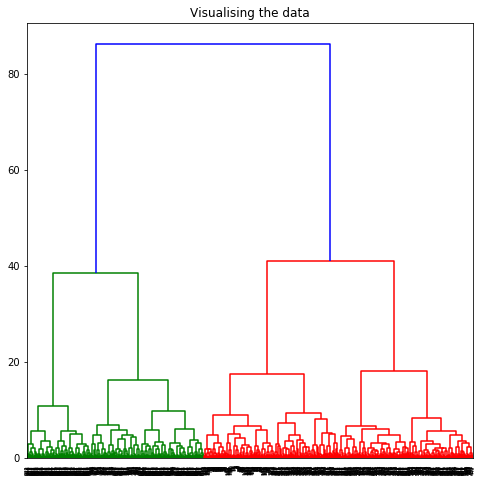

In [159]:
plt.figure(figsize =(8, 8)) 
plt.title('Visualising the data') 
Dendrogram = shc.dendrogram((shc.linkage(data, method ='ward')))

In [165]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=40, affinity='euclidean', linkage='ward').fit(data)
cluster

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=40,
                        pooling_func='deprecated')

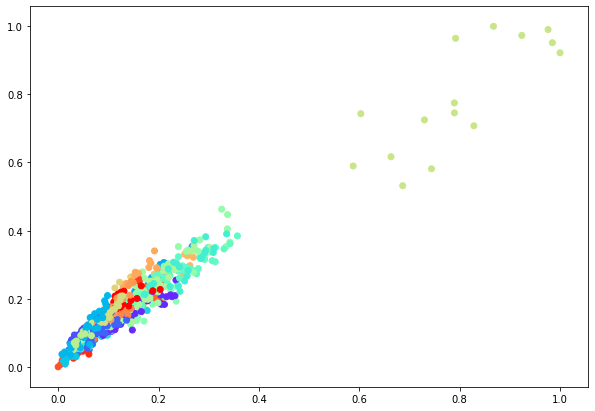

In [167]:
plt.figure(figsize=(10, 7))
plt.scatter(data[:,0], data[:,1], c=cluster.labels_, cmap='rainbow')

#### <span>DBSCAN</span>

In [48]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

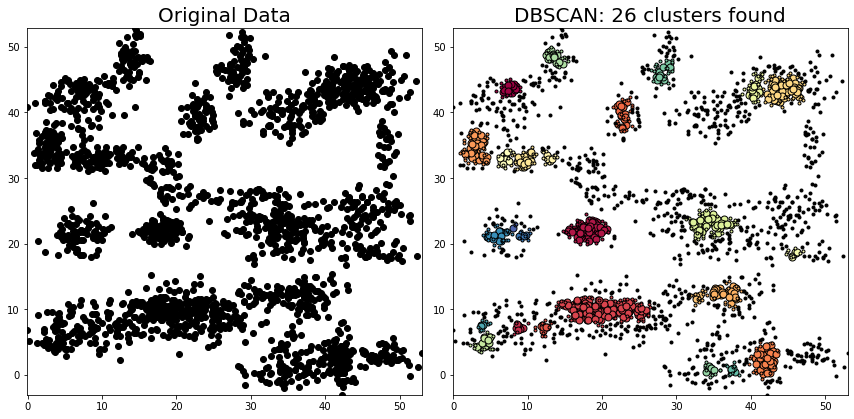

In [49]:
def generate_cluster(n_clusters, pts_minmax=(10, 100), x_mult=(1, 4), y_mult=(1, 3), 
                x_off=(0, 50), y_off=(0, 50)):
    
    clusters_x = []
    clusters_y = []
    
    n_points = np.random.randint(pts_minmax[0], pts_minmax[1], n_clusters)
    x_multipliers = np.random.randint(x_mult[0], x_mult[1], n_clusters)
    y_multipliers = np.random.randint(y_mult[0], y_mult[1], n_clusters)
    x_offsets = np.random.randint(x_off[0], x_off[1], n_clusters)
    y_offsets = np.random.randint(y_off[0], y_off[1], n_clusters)
     
    for idx, npts in enumerate(n_points):
        
        xpts = np.random.randn(npts) * x_multipliers[idx] + x_offsets[idx]
        ypts = np.random.randn(npts) * y_multipliers[idx] + y_offsets[idx]
        clusters_x.append(xpts)
        clusters_y.append(ypts)
    
    return clusters_x, clusters_y      # returns cluster positions




# Generate clusters
n_clusters = 40
clusters_x, clusters_y = generate_cluster(n_clusters)

# Convert to a single dataset 
data = np.float32((np.concatenate(clusters_x), np.concatenate(clusters_y))).transpose()

db = DBSCAN(eps=1, min_samples=10, metric='euclidean').fit(data)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
unique_labels = set(labels)

# Plotting the original data
min_x = np.min(data[:, 0])
max_x = np.max(data[:, 0])
min_y = np.min(data[:, 1])
max_y = np.max(data[:, 1])

fig = plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(data[:,0], data[:,1], 'ko')
plt.xlim(min_x, max_x)
plt.ylim(min_y, max_y)
plt.title('Original Data', fontsize = 20)

# Plotting the clustered data

plt.subplot(122)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = data[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=7)

    xy = data[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=3)
plt.xlim(min_x, max_x)
plt.ylim(min_y, max_y)
plt.title('DBSCAN: %d clusters found' % n_clusters, fontsize = 20)
fig.tight_layout()
plt.subplots_adjust(left=0.03, right=0.98, top=0.9, bottom=0.05)


## <span style="color:#900C3F;">4. Comparing the performance of classification models</span>

## Conclusion

#### References: 